In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
from math import comb
import pymc3 as pm
import arviz as az

# Problem 1

In [12]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    
    # The number of successes
    sum_xi = np.random.binomial(n, p)

    # The MAP (= MLE since assuming a uniform prior) after solving by hand
    MAP = sum_xi/n

    # The numerator of the posterior distribution using a uniform prior,
    # calculated at xN values of x between 0 and 1
    xN = 1000
    x = np.linspace(0, 1, xN)
    numerator = x**sum_xi * (1-x)**(n-sum_xi)

    # An approximation of the the denominator of the posterior distribution using a uniform prior
    # and N values of the parameter t between 0 and 1
    N = 1000
    denominator = sum([t**sum_xi * (1-t)**(n-sum_xi) for t in np.linspace(0, 1, N)])/N

    # The value of the posterior at xN values of x between 0 and 1
    y = numerator/denominator

    # Plot the posterior
    plt.plot(x, y)
    plt.title('Posterior distribution')
    plt.show()

    # Return the MAP
    return MAP
    

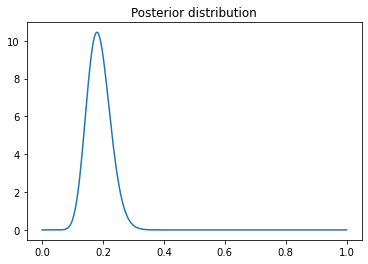

0.18


In [13]:
print(bernoulli_sampling(0.2, 100))

# Problem 2

In [14]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    
    # The number of successes
    sum_xi = np.random.binomial(n, p)

    # The numerator of the posterior distribution using a uniform prior,
    # calculated at xN values of x between 0 and 1
    xN = 1000
    x = np.linspace(0, 1, xN)
    numerator = x**sum_xi * (1-x)**(n-sum_xi) * prior.pdf(x)

    # An approximation of the the denominator of the posterior distribution using a uniform prior
    # and N values of the parameter t between 0 and 1
    N = 1000
    denominator = sum([t**sum_xi * (1-t)**(n-sum_xi) * prior.pdf(t) for t in np.linspace(0, 1, N)])/N

    # The value of the posterior at xN values of x between 0 and 1
    y = numerator/denominator

    # Estimate the MAP
    MAP = x[np.argmax(y)]

    # Plot the posterior
    plt.plot(x, y)
    plt.title(f'Posterior distribution: coin p={p}')
    plt.show()

    # Return the estimated MAP
    return MAP

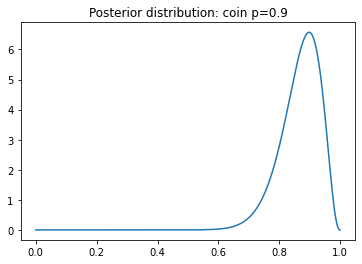

0.8978978978978979


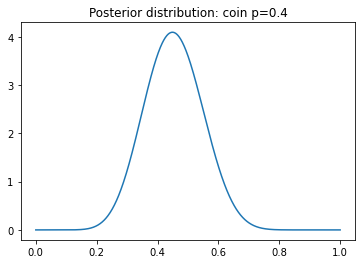

0.4494494494494494


In [15]:
dist = beta(5, 1.5)
print(non_uniform_prior(0.9, 20, dist))
print(non_uniform_prior(0.4, 20, dist))

# Problem 3

In [16]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. Return a list of strings, not including the 0th day.
    """

    # Map weather to index in transition matrix
    weather_index = {'sun' : 0, 'rain' : 1, 'wind' : 2}

    # Create a list for the days, assuming the 0th day is sunny
    days = ['sun'] + [None] * days

    # Iterate through each day in days and predict the future I mean forecast the weather
    # using the transition matrix
    for i in range(1, len(days[1:]) + 1):
        prev_day_weather_index = weather_index[days[i-1]]
        days[i] = np.random.choice(list(weather_index.keys()), p=transition_matrix[prev_day_weather_index])
    return days[1:]

In [17]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)

In [18]:
print(weather_forecast(transition_matrix, 10))

['sun', 'sun', 'sun', 'wind', 'wind', 'sun', 'sun', 'sun', 'wind', 'rain']


# Problem 4

In [19]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Plot the trace plot and return the expected value of
    the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    
    model = pm.Model()
    with model:
        # Define the prior of p as a Beta(1, 1) distribution
        p = pm.Beta('p', alpha=1, beta=1)

        # Define the likelihood of the data to be distributed as Bernoulli(p)
        y = pm.Bernoulli('y', p=p, observed=data)

        # Sample from the posterior
        trace = pm.sample(n)

        # Plot the posterior and trace plot for p
        az.plot_trace(trace)

        # Trace values of p as a list
        new_p = trace['p']

        # Get the mean
        mean = new_p.mean()

        return mean

c:\ProgramData\Anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 41 seconds.


0.15838350439014134


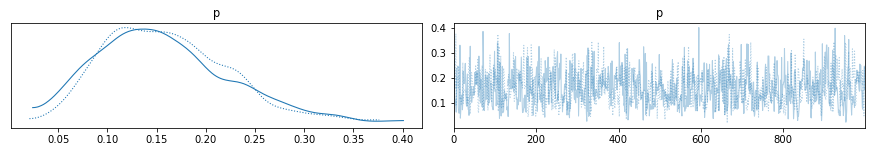

In [20]:
data = bernoulli.rvs(0.2, size=30)
print(posterior_sampling(data, 1000))

# Problem 5

In [23]:
def height_model(observed_heights, m=180, s=10, alpha=2, beta=10, n=1000):
    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu, 1/tau) where mu has a prior of Normal(m, s), 
    and tau has a prior of Gamma(alpha, beta). Set up a PyMC3 model for this 
    situation and sample from the poterior n times. Plot the trace plots for 
    mu and tau, and return the expected value of the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    
    model = pm.Model()
    with model:
        # Define the prior of mu as a Normal(m, s) distribution
        mu = pm.Normal('mu', mu=m, sigma=s)

        # Define the prior of tau as a Gamma(alpha, beta) distribution
        tau = pm.Gamma('tau', alpha=alpha, beta=beta)

        # Define the likelihood of the data to be distributed as Normal(mu, 1/tau)
        y = pm.Normal('y', mu=mu, tau=tau, observed=observed_heights)

        # Sample from the posterior
        trace = pm.sample(n)

        # Plot the posterior and trace plot for mu and tau
        az.plot_trace(trace)

         # Trace values of mu as a list
        new_mu = trace['mu']

        # Get the mean
        mean = new_mu.mean()

        return mean

c:\ProgramData\Anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.


158.6770833057168


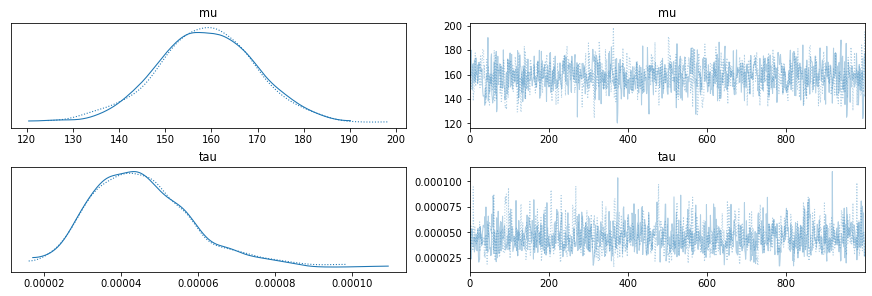

In [24]:
heights = np.random.normal(180,10,100)
print(height_model(data))